In [ ]:
# Run in Colab to install local packages
!pip install datasets gensim sentence_transformers tqdm

In [20]:
import os
import datasets
import gensim
import gensim.downloader
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
sciq = datasets.load_dataset("allenai/sciq")

In [4]:
train = sciq["train"]

In [8]:
print(train[0])

{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


## Length of answers and distractors

In [12]:
def get_max_length(sample):
    return {
        "max_length":max([len(sample[y].split(" ")) for y in ["correct_answer", "distractor1", "distractor2", "distractor3"]])
    }
train =  train.map(get_max_length, remove_columns=["question", "support"])

Map:   0%|          | 0/11679 [00:00<?, ? examples/s]

In [42]:
train_df = train
train_df.set_format("pandas")
train_df = train_df[:]
train_df["len_correct_answer"] = train_df["correct_answer"].apply(lambda x: len(x.split(" ")))
# train_df["max_len"] = train.map(lambda x: max([len(x[y].split(" ")) for y in ["correct_answer", "distractor1", "distractor2", "distractor3"]]))

frequencies = (
#     train_df["len_correct_answer"]
    bla["max_length"]
    .value_counts()
    .to_frame()
    .reset_index()
#     .rename(columns={"index": "number of words", "len_correct_answer": "frequency"})
)
train.set_format()
frequencies

,index,max_length
0,1,6204
1,2,4018
2,3,1142
3,4,196
4,5,64
5,6,26
6,7,14
7,8,5
8,9,3
9,10,3


## Word embeddings

In [6]:
# fasttext = gensim.downloader.load("fasttext-wiki-news-subwords-300")
# fasttext = gensim.models.KeyedVectors.load("ft") #, mmap='r'

In [7]:
print(fasttext.similarity('viruses', 'protozoa'))
print(fasttext.similarity('protozoa', 'viruses'))

0.52428013
0.52428013


In [9]:
small = train.select([i for i in range(10)])
print(small)
print(small[0])

Dataset({
    features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
    num_rows: 10
})
{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


In [63]:
ansToDist = []
distToDist = []
for i, sample in enumerate(train):
    if sample["max_length"] > 1:
        continue
    try:
        sim = [fasttext.similarity(sample["correct_answer"], sample[distractor]) for distractor in ["distractor1", "distractor2", "distractor3"]]
        ansToDist.extend(sim)
        if max(sim) >= 1.0:
            print(i)
        sim = [fasttext.similarity(sample["distractor"+str(a)], sample["distractor"+str(b)]) for a, b in [(1,2), (1,3), (2,3)]]
        distToDist.extend(sim)
    except KeyError:
        continue

1481
4997
5387
5558
11108
11116


In [48]:
len(ansToDist)

17109

In [54]:
ansToDistDF = pd.DataFrame(ansToDist)
ansToDistDF.describe()

,0
count,17109.000000
mean,0.511500
std,0.141269
min,-0.056659
25%,0.420177
50%,0.496206
75%,0.589245
max,1.000000


In [53]:
distToDistDF = pd.DataFrame(distToDist)
distToDistDF.describe()

,0
count,17109.000000
mean,0.469450
std,0.139733
min,-0.020514
25%,0.377366
50%,0.456741
75%,0.544530
max,1.000000


In [57]:
npAnsToDist = np.array(ansToDist)

(array([  11.,   39.,  323., 1806., 4843., 5349., 2962., 1074.,  341.,
         361.]),
 array([-0.05665937,  0.04900656,  0.1546725 ,  0.26033843,  0.36600438,
         0.4716703 ,  0.57733625,  0.6830022 ,  0.7886681 ,  0.8943341 ,
         1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

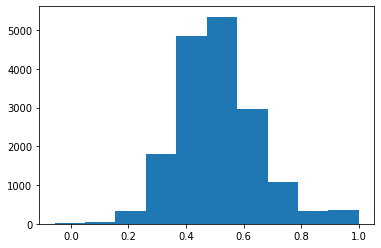

In [69]:
plt.hist(npAnsToDist, bins=10)

(array([  13.,  137.,  987., 3686., 5565., 3900., 1762.,  622.,  194.,
         243.]),
 array([-0.02051357,  0.08153778,  0.18358915,  0.2856405 ,  0.38769186,
         0.4897432 ,  0.59179455,  0.6938459 ,  0.7958973 ,  0.8979486 ,
         1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

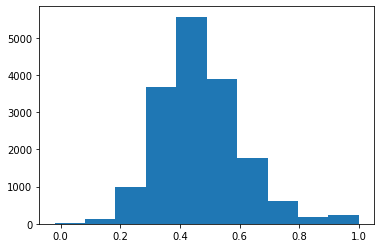

In [70]:
plt.hist(distToDist, bins=10)

## Sentence embeddings

In [9]:
model = SentenceTransformer("all-mpnet-base-v2") # See for other pretrained models: https://www.sbert.net/docs/pretrained_models.html

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
samp = train[0]
print(samp)
emb = model.encode(samp['correct_answer'])
print(emb)

{'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'max_length': 2}
[-2.15632617e-02 -8.02733600e-02 -9.92457569e-03 -4.93398309e-02
 -7.71961128e-03  6.10115705e-03 -2.83632148e-02  6.27047662e-03
  5.15939593e-02 -2.11948976e-02 -3.06289122e-02  1.40945138e-02
 -6.62956163e-02  1.94567516e-02  2.40543690e-02 -5.96627872e-03
  5.04675731e-02 -2.54681986e-02 -1.06249273e-01 -1.96286999e-02
 -6.83179796e-02 -1.50031131e-02  2.75282282e-02 -6.04318120e-02
  7.05722496e-02  2.45534088e-02 -3.72297689e-03 -4.96702753e-02
  1.95645932e-02 -1.37993693e-02 -2.24583014e-03 -5.60772046e-03
  2.02012435e-02 -1.51949869e-02  1.00496118e-06 -2.88647916e-02
 -3.68663035e-02 -3.72930802e-02 -9.64345597e-03 -1.06541580e-03
 -8.75620265e-03  1.68595149e-03  1.12800533e-02  3.91934216e-02
  2.94562057e-02 -1.74050219e-02  5.23713827e-02 -3.89471576e-02
 -2.79050861e-02 -3.48614566e-02 -8.30301456e-03  4.78190137e-03
 -2.15057936

In [ ]:
ansToDist = []
distToDist = []

for i, sample in enumerate(tqdm(train)):
    keys_to_encode = ["correct_answer", "distractor1", "distractor2", "distractor3"]
    strings_to_encode = [sample[j] for j in keys_to_encode]
    embeddings = {key: value for key, value in zip(keys_to_encode, model.encode(strings_to_encode))}

    sim = [util.cos_sim(embeddings["correct_answer"], embeddings[distractor]) for distractor in ["distractor1", "distractor2", "distractor3"]]
    ansToDist.extend(sim)
    
    sim = [util.cos_sim(embeddings["distractor"+str(a)],embeddings["distractor"+str(b)]) for a, b in [(1,2), (1,3), (2,3)]]
    distToDist.extend(sim)

ansToDist = [tensor.item() for tensor in ansToDist]
distToDist = [tensor.item() for tensor in distToDist]

 30%|██▉       | 3449/11679 [01:28<03:27, 39.74it/s]

In [39]:
ansToDistDF = pd.DataFrame(ansToDist)
ansToDistDF.describe()

,0
count,18612.000000
mean,0.413126
std,0.153072
min,-0.045217
25%,0.301925
50%,0.397536
75%,0.505426
max,1.000000


In [38]:
distToDistDF = pd.DataFrame(distToDist)
distToDistDF.describe()

,0
count,18612.000000
mean,0.375359
std,0.148541
min,-0.015780
25%,0.266006
50%,0.357596
75%,0.469792
max,1.000000


In [ ]:
plt.hist(ansToDist, bins=10)

In [ ]:
plt.hist(distToDist, bins=10)

## Old code

In [7]:
def get_similarities(sample):
    if len(sample["correct_answer"].split(' ')) > 1:
        return {
             "correct_to_distractor": [None],
            "distractor_to_distractor": [None],
        }
    try:
        return {
            "correct_to_distractor": [fasttext.similarity(sample["correct_answer"], sample[distractor]) for distractor in ["distractor1", "distractor2", "distractor3"]],
            "distractor_to_distractor": [fasttext.similarity(sample["distractor"+str(a)], sample["distractor"+str(b)]) for a, b in [(1,2), (1,3), (2,3)]],
        }
    except KeyError:
        return {
             "correct_to_distractor": [None],
            "distractor_to_distractor": [None],
        }

### Finding bad samples

In [ ]:
np.argmax(npAnsToDist)
train[1481]